# EXPERIMENT NO: 03 ---- KMEANS CLUSTERING


## **THEORY**

### 1. Mention the k-means algorithm
**Clustering** is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identifying subgroups in the data such that data points in the same subgroup (cluster) are very similar while data points in different clusters are very different

**Kmeans algorithm** is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

**The way kmeans algorithm works is as follows:**

1.Specify number of clusters K.

2.Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.

3.Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.
- Compute the sum of the squared distance between data points and all centroids.
- Assign each data point to the closest cluster (centroid).
- Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

**Example of Clusters and its centers**

<img src = "https://miro.medium.com/max/396/1*dLrogayyf5UaLXD_8cmzpw.png" alt ="Kmeans Example">

### 2. How is pyspark used in the formation of clusters?

Apache Spark is a cluster computing system with many application areas including structured data processing, machine learning, and graph processing. 

Using Pyspark we can create a Rdd. On that Rdd, we can takeSamples for centroids and we can apply the kmeans algorithm on it.

Number of clusters, k, is defined in advance. The centers of clusters and the data points in each cluster are adjusted via an iterative algorithm to finally define k clusters. There is an underlying cost minimization objective where the cost function is so-called Within-Cluster Sum of Squares (WCSS).

Spark MLlib library provides an implementation for K-means clustering.

## **IMPLEMENTATION**

In [1]:
from __future__ import print_function
import sys
import numpy as np
from pyspark.sql import SparkSession

In [2]:
def parseVector(line):
    return np.array([float(x) for x in line.split(' ')])

In [3]:
# Code used to generate Data
# import random
# for i in range(30):
#     with open("kmeans.txt","a+") as f:
#         f.write( str(random.uniform(0,10)) +" "+ str(random.uniform(0,10))+"\n")
#         f.close()

In [4]:
def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

In [5]:
spark = SparkSession\
    .builder\
    .appName("PythonKMeans")\
    .getOrCreate()

In [6]:
lines = spark.read.text("kmeans.txt").rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()
    
# print(data.take(100))
print(data.collect())
d = data.collect()

[array([9.08252447, 7.12390287]), array([9.33817812, 6.71793837]), array([0.01933314, 2.96684167]), array([7.57000166, 2.58287434]), array([1.70282924, 7.87202264]), array([2.39969822, 1.82435878]), array([4.06604017, 9.02306186]), array([8.69574466, 4.47057342]), array([5.40661369, 7.83456904]), array([1.67240597, 3.25608017]), array([1.44058591, 1.94428684]), array([0.81741122, 8.8801701 ]), array([2.69594823, 6.15924369]), array([6.27848157, 8.4410247 ]), array([3.67420366, 6.93338035]), array([3.50520283, 9.80406601]), array([4.59580223, 2.61772693]), array([6.43876655, 7.96249263]), array([9.91214714, 2.77336834]), array([2.7730827, 0.3764207]), array([2.76707781, 7.80534693]), array([5.32984029, 2.52836244]), array([9.89334113, 1.74211155]), array([3.99531476, 3.17221429]), array([7.7022596, 3.3354966]), array([2.020522  , 1.55985086]), array([8.69632327, 1.78274322]), array([2.50724855, 6.62596412]), array([1.71573307, 7.57173923]), array([2.29760227, 0.87786019])]


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# To Plot Data
def plot(centroids,data):
    for i, pts in data:
        x,y = [],[]
        for pt in pts:
            x.append(pt[0][0])
            y.append(pt[0][1])
        plt.scatter(x,y)
    for pts in centroids:
        plt.scatter(pts[0],pts[1], marker="*", color='red', linewidth=2)
    plt.show()

K = 1
Centroids are : [array([4.63367547, 4.88553643])]


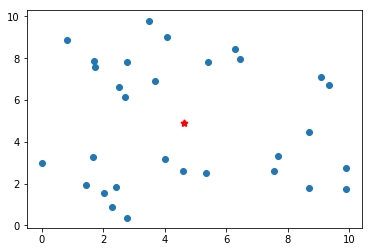

K = 2
Centroids are : [array([4.28544708, 7.76820875]), array([4.93837531, 2.36319815])]


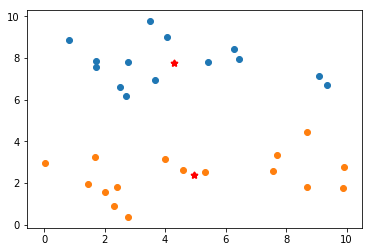

K = 3
Centroids are : [array([8.86131501, 3.81612609]), array([3.46462972, 7.90942344]), array([2.65441875, 2.11240029])]


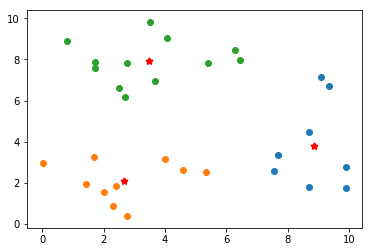

K = 4
Centroids are : [array([4.64031909, 2.77276789]), array([3.46462972, 7.90942344]), array([1.8033186, 1.8293856]), array([8.86131501, 3.81612609])]


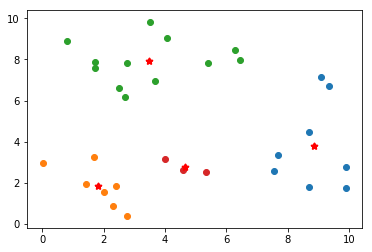

K = 5
Centroids are : [array([9.03881575, 6.10413822]), array([3.46462972, 7.90942344]), array([1.8033186, 1.8293856]), array([8.75481456, 2.44331881]), array([4.64031909, 2.77276789])]


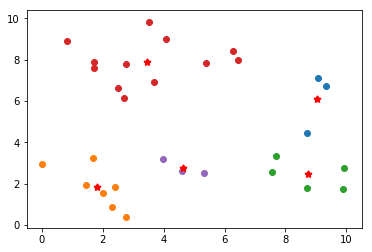

In [9]:
def kmeans(data,k,iters):
    kPoints = data.takeSample(False, k, 42)
    for i in range(iters+1):
        closest = data.map(lambda p: (closestPoint(p, kPoints), (p, 1)))
        pointStats = closest.reduceByKey(lambda pc1, pc2: (pc1[0] + pc2[0], pc1[1] + pc2[1]))
        newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()
        tempDist = sum(np.sum((kPoints[iK] - p) ** 2) for (iK, p) in newPoints)

        if(tempDist == 0):
            break
            
        for (iK, p) in newPoints:
            kPoints[iK] = p
    print("K = {}".format(k))
    print("Centroids are : {}".format(kPoints))
    plot(kPoints,closest.groupByKey().collect())
    return kPoints

centers = []

# Running Kmeans 5 times
for i in range(1,6):
    centers.append(kmeans(data,i,10))

In [10]:
spark.stop()